# I Load packages

In [1]:
import pandas as pd
import os as os
import torch
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings # supress warnings
from sklearn.preprocessing import MinMaxScaler

import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math

warnings.filterwarnings('ignore')

In [2]:
warnings.filterwarnings('ignore')
base_path = os.getcwd()
proj_path = base_path.replace("00_Code", "")
print(base_path)
print(proj_path)
os.chdir(proj_path)
# print("Path now set to: " + os.getcwd())

F:\Fiverr_June\Frank_Germany
F:\Fiverr_June\Frank_Germany


In [3]:
torch.manual_seed(1234)
np.random.seed(1234)

## Load and prepare data

In [4]:
df_books_data = pd.read_csv("0006_02_01_books_upsampled_MLbase.csv")
df_books_data.describe()

df_books_data.dtypes

df_books_data = df_books_data.drop(columns=['n_small',
                                            'n_big',
                                            'description'])

df_books_data['cat'] = df_books_data['cat'].astype('category')
df_books_data['subcat'] = df_books_data['subcat'].astype('category')
df_books_data['price'] = df_books_data['price'].str.replace("$", "")
df_books_data['price'] = df_books_data['price'].astype('float')


In [5]:
df_books_data_model_NAs = df_books_data[df_books_data.isna().any(axis=1)]
df_books_data_model_NAs.head()

,j1,j2,j3,j4,j5,p1,p2,p3,p4,p5,...,p3_sampled,p4_sampled,p5_sampled,is_j_to_p_upsampling,n_unfreq,n_freq,rank,price,cat,subcat
0,0.090909,0.077922,0.064935,0.116883,0.649351,0.016260,0.016260,0.085366,0.227642,0.654472,...,0.085366,0.227642,0.654472,0.0,77,246,"18,682,789inBooks(",NaN,"New, Used & Rental Textbooks",Humanities
5,0.056842,0.025263,0.090526,0.170526,0.656842,0.016760,0.022346,0.134078,0.217877,0.608939,...,0.103158,0.250526,0.604211,1.0,475,179,"8,860,820inBooks(",NaN,"Mystery, Thriller & Suspense",Thrillers & Suspense
7,0.147089,0.040858,0.056180,0.104188,0.651685,0.049505,0.019802,0.039604,0.079208,0.811881,...,0.046987,0.073544,0.803882,1.0,979,101,"17,680,361inBooks(",NaN,Christian Books & Bibles,Bibles
17,0.041096,0.016860,0.056902,0.190727,0.694415,0.031034,0.051724,0.086207,0.244828,0.586207,...,0.069547,0.272919,0.576396,1.0,949,290,"9,903,645inBooks(",5.99,Teen & Young Adult,NaN
19,0.030181,0.014085,0.026157,0.034205,0.895372,0.006098,0.000000,0.012195,0.060976,0.920732,...,0.007042,0.055332,0.935614,1.0,994,164,"234,981inBooks(",7.03,"s Books"",",NaN


In [6]:
print(len(df_books_data)) # 2989
df_books_data_model = df_books_data.dropna()
print(len(df_books_data_model)) #2076

2989
2185


In [7]:

df_books_data_model['n_revs_sampled'] = np.where((df_books_data_model['n_freq'] >= df_books_data_model['n_unfreq']),
                                                 df_books_data_model['n_freq'],
                                                 df_books_data_model['n_unfreq'])

df_books_data_model = df_books_data_model.drop(columns=['j1', 'j2', 'j3', 'j4', 'j5',
                                                        'p1', 'p2', 'p3', 'p4', 'p5',
                                                         'is_j_to_p_upsampling',
                                                        'n_unfreq', 'n_freq'
                                                        #, 'asin'
                                                        ])

df_books_data_model = df_books_data_model.rename({'j1_sampled': 'j1',
                                                  'j2_sampled': 'j2',
                                                  'j3_sampled': 'j3',
                                                  'j4_sampled': 'j4',
                                                  'j5_sampled': 'j5',
                                                  'p1_sampled': 'p1',
                                                  'p2_sampled': 'p2',
                                                  'p3_sampled': 'p3',
                                                  'p4_sampled': 'p4',
                                                  'p5_sampled': 'p5',
                                                  'cat': 'categoriezz',
                                                  'subcat': 'subcategoriezz'
                                                  }, axis=1)  # new method


del df_books_data
df_books_data_model.head()



,asin,id,j1,j2,j3,j4,j5,p1,p2,p3,p4,p5,rank,price,categoriezz,subcategoriezz,n_revs_sampled
1,0001720295,2,0.039773,0.011364,0.039773,0.119318,0.789773,0.017045,0.000000,0.090909,0.130682,0.761364,"137,964inBooks(",12.59,Humor & Entertainment,Radio,176
2,0001844423,3,0.035857,0.019920,0.033865,0.079681,0.830677,0.045817,0.055777,0.083665,0.183267,0.631474,"5,818,930inBooks(",25.85,Christian Books & Bibles,Literature & Fiction,502
3,0002005883,4,0.074074,0.064815,0.074074,0.157407,0.629630,0.064815,0.092593,0.175926,0.166667,0.500000,"5,686,643inBooks(",60.18,Literature & Fiction,Contemporary,108
4,0002247399,5,0.024768,0.026316,0.069659,0.164087,0.715170,0.009288,0.043344,0.111455,0.154799,0.681115,"3,396,965inBooks(",29.07,Science Fiction & Fantasy,Fantasy,646
6,0004244079,7,0.100629,0.047170,0.044025,0.113208,0.694969,0.015723,0.031447,0.100629,0.182390,0.669811,"15,607,529inBooks(",11.89,Literature & Fiction,Genre Fiction,318


## Rescaling (Normalization)


In [8]:
df_books_data_model.head()
df_books_data_model_unscaled = df_books_data_model.copy()

In [9]:
cols_to_normalize = [
    #    'j1', 'j2', 'j3', 'j4', 'j5',
    #    'p1', 'p2', 'p3', 'p4', 'p5',
    #    'polarity_j',
    #    'polarity_p',
    #   'posimbalance_j',
    'price', 'n_revs_sampled'
]

scaler = MinMaxScaler()
df_books_data_model[cols_to_normalize] = scaler.fit_transform(df_books_data_model[cols_to_normalize])

In [10]:
df_books_data_model.head()

,asin,id,j1,j2,j3,j4,j5,p1,p2,p3,p4,p5,rank,price,categoriezz,subcategoriezz,n_revs_sampled
1,0001720295,2,0.039773,0.011364,0.039773,0.119318,0.789773,0.017045,0.000000,0.090909,0.130682,0.761364,"137,964inBooks(",0.019644,Humor & Entertainment,Radio,0.007583
2,0001844423,3,0.035857,0.019920,0.033865,0.079681,0.830677,0.045817,0.055777,0.083665,0.183267,0.631474,"5,818,930inBooks(",0.041812,Christian Books & Bibles,Literature & Fiction,0.029269
3,0002005883,4,0.074074,0.064815,0.074074,0.157407,0.629630,0.064815,0.092593,0.175926,0.166667,0.500000,"5,686,643inBooks(",0.099204,Literature & Fiction,Contemporary,0.003060
4,0002247399,5,0.024768,0.026316,0.069659,0.164087,0.715170,0.009288,0.043344,0.111455,0.154799,0.681115,"3,396,965inBooks(",0.047195,Science Fiction & Fantasy,Fantasy,0.038848
6,0004244079,7,0.100629,0.047170,0.044025,0.113208,0.694969,0.015723,0.031447,0.100629,0.182390,0.669811,"15,607,529inBooks(",0.018473,Literature & Fiction,Genre Fiction,0.017029


## Add polarity and imbalance values

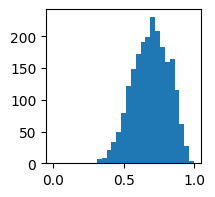

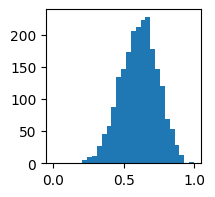

In [11]:
# from Schoenmueller et al. (2021)
# polarity scores
df_books_data_model['polarity_j'] = df_books_data_model['j1'] + df_books_data_model['j5']

bins = np.linspace(0,1,30,endpoint=True)
plt.figure(figsize=(2,2)) #change your figure size as per your desire here
plt.hist(df_books_data_model[['polarity_j']], bins=bins)
plt.show()

df_books_data_model['polarity_p'] = df_books_data_model['p1'] + df_books_data_model['p5']

bins = np.linspace(0,1,30,endpoint=True)
plt.figure(figsize=(2,2)) #change your figure size as per your desire here
plt.hist(df_books_data_model[['polarity_p']], bins=bins)
plt.show()



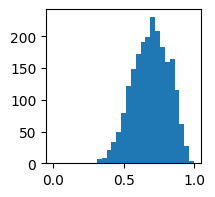

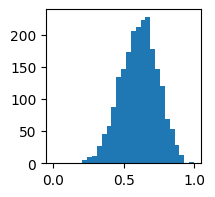

In [12]:
#drop low polarity scores
#df_books_data_model = df_books_data_model.drop(df_books_data_model[(df_books_data_model['polarity_j'] <= 0.4)].index)
#df_books_data_model = df_books_data_model.drop(df_books_data_model[(df_books_data_model['polarity_p'] > 0.65)].index)

bins = np.linspace(0,1,30,endpoint=True)
plt.figure(figsize=(2,2)) #change your figure size as per your desire here
plt.hist(df_books_data_model[['polarity_j']], bins=bins)
plt.show()

bins = np.linspace(0,1,30,endpoint=True)
plt.figure(figsize=(2,2)) #change your figure size as per your desire here
plt.hist(df_books_data_model[['polarity_p']], bins=bins)
plt.show()


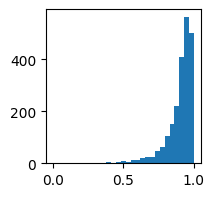

In [13]:
# positive imbalance scores
df_books_data_model['posimbalance_j'] = (df_books_data_model['j4'] + df_books_data_model['j5']) / (df_books_data_model['j1'] + df_books_data_model['j2'] + df_books_data_model['j4'] + df_books_data_model['j5'])

bins = np.linspace(0,1,30,endpoint=True)
plt.figure(figsize=(2,2)) #change your figure size as per your desire here
plt.hist(df_books_data_model[['posimbalance_j']], bins=bins)
plt.show()


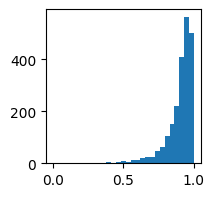

In [14]:
#drop low positive imbalance scores
#df_books_data_model = df_books_data_model.drop(df_books_data_model[(df_books_data_model['posimbalance_j'] <= 0.50)].index)

bins = np.linspace(0,1,30,endpoint=True)
plt.figure(figsize=(2,2)) #change your figure size as per your desire here
plt.hist(df_books_data_model[['posimbalance_j']], bins=bins)
plt.show()


## Rearrange DF

In [15]:
df_books_data_model_copy = df_books_data_model
#df_books_data_model = df_books_data_model.drop(['asin'], axis=1)
df_books_data_model['init_index'] = df_books_data_model.index.values

df_books_data_model = df_books_data_model[['init_index',
                                           'p1', 'p2', 'p3', 'p4', 'p5',
                                           'j1', 'j2', 'j3', 'j4', 'j5',
                                           'polarity_j',
                                           'polarity_p',
                                           #'posimbalance_j',
                                           'price', 'n_revs_sampled', 'categoriezz', 'subcategoriezz']]

In [16]:
df_books_data_model.head()

,init_index,p1,p2,p3,p4,p5,j1,j2,j3,j4,j5,polarity_j,polarity_p,price,n_revs_sampled,categoriezz,subcategoriezz
1,1,0.017045,0.000000,0.090909,0.130682,0.761364,0.039773,0.011364,0.039773,0.119318,0.789773,0.829545,0.778409,0.019644,0.007583,Humor & Entertainment,Radio
2,2,0.045817,0.055777,0.083665,0.183267,0.631474,0.035857,0.019920,0.033865,0.079681,0.830677,0.866534,0.677291,0.041812,0.029269,Christian Books & Bibles,Literature & Fiction
3,3,0.064815,0.092593,0.175926,0.166667,0.500000,0.074074,0.064815,0.074074,0.157407,0.629630,0.703704,0.564815,0.099204,0.003060,Literature & Fiction,Contemporary
4,4,0.009288,0.043344,0.111455,0.154799,0.681115,0.024768,0.026316,0.069659,0.164087,0.715170,0.739938,0.690402,0.047195,0.038848,Science Fiction & Fantasy,Fantasy
6,6,0.015723,0.031447,0.100629,0.182390,0.669811,0.100629,0.047170,0.044025,0.113208,0.694969,0.795597,0.685535,0.018473,0.017029,Literature & Fiction,Genre Fiction


## Categories cleaning & dummies

In [17]:
# What categories do we have?
subcatz = df_books_data_model.subcategoriezz.unique().tolist()
catz = df_books_data_model.categoriezz.unique().tolist()
print(len(subcatz))
len_subcatz = len(subcatz)

print(len(catz))
len_catz = len(catz)

102
28


In [18]:
sorted(subcatz)

['Accounting',
 'Action & Adventure',
 'Alternative Medicine',
 'Americas',
 'Ancient Civilizations',
 'Anthologies',
 'Arts & Literature',
 'Asia',
 'Bible Study & Reference',
 'Bibles',
 'Biological Sciences',
 'British & Irish',
 'Christian Living',
 'Classics',
 'Contemporary',
 'Cooking Methods',
 'Crafts & Hobbies',
 'Creativity',
 'Death & Grief',
 'Decorative Arts & Design',
 'Diets & Weight Loss',
 'Diseases & Physical Ailments',
 'Dramas & Plays',
 'Economics',
 'Education & Reference',
 'Engineering',
 'Entertaining & Holidays',
 'Erotica',
 'Essays & Correspondence',
 'Europe',
 'Family Relationships',
 'Fantasy',
 'Genre Fiction',
 'Gothic',
 'Graphic Design',
 'Graphic Novels',
 'Happiness',
 'Hardware & DIY',
 'Historical',
 'History & Criticism',
 'Home Improvement & Design',
 'Humor',
 'Humor & Satire',
 'Individual Artists',
 'Individual Sports',
 'Investing',
 'Job Hunting & Careers',
 'LGBT',
 'Leaders & Notable People',
 'Literary',
 'Literature & Fiction',
 'Manag

In [19]:
sorted(catz)

['Arts & Photography',
 'Biographies & Memoirs',
 'Business & Money',
 'Christian Books & Bibles',
 'Comics & Graphic Novels',
 'Computers & Technology',
 'Cookbooks, Food & Wine',
 'Crafts, Hobbies & Home',
 'Education & Teaching',
 'Engineering & Transportation',
 'Health, Fitness & Dieting',
 'History',
 'Humor & Entertainment',
 'Lesbian, Gay, Bisexual & Transgender Books',
 'Literature & Fiction',
 'Medical Books',
 'Mystery, Thriller & Suspense',
 'Parenting & Relationships',
 'Politics & Social Sciences',
 'Reference',
 'Religion & Spirituality',
 'Romance',
 'Science & Math',
 'Science Fiction & Fantasy',
 'Self-Help',
 'Sports & Outdoors',
 'Teen & Young Adult',
 'Travel']

In [20]:
# Get dummies

# Cats conatin spaces- replace
df_books_data_model['categoriezz'] = df_books_data_model['categoriezz'].str.replace(' ', '_')
df_books_data_model['subcategoriezz'] = df_books_data_model['subcategoriezz'].str.replace(' ', '_')

df_books_data_model.head()

,init_index,p1,p2,p3,p4,p5,j1,j2,j3,j4,j5,polarity_j,polarity_p,price,n_revs_sampled,categoriezz,subcategoriezz
1,1,0.017045,0.000000,0.090909,0.130682,0.761364,0.039773,0.011364,0.039773,0.119318,0.789773,0.829545,0.778409,0.019644,0.007583,Humor_&_Entertainment,Radio
2,2,0.045817,0.055777,0.083665,0.183267,0.631474,0.035857,0.019920,0.033865,0.079681,0.830677,0.866534,0.677291,0.041812,0.029269,Christian_Books_&_Bibles,Literature_&_Fiction
3,3,0.064815,0.092593,0.175926,0.166667,0.500000,0.074074,0.064815,0.074074,0.157407,0.629630,0.703704,0.564815,0.099204,0.003060,Literature_&_Fiction,Contemporary
4,4,0.009288,0.043344,0.111455,0.154799,0.681115,0.024768,0.026316,0.069659,0.164087,0.715170,0.739938,0.690402,0.047195,0.038848,Science_Fiction_&_Fantasy,Fantasy
6,6,0.015723,0.031447,0.100629,0.182390,0.669811,0.100629,0.047170,0.044025,0.113208,0.694969,0.795597,0.685535,0.018473,0.017029,Literature_&_Fiction,Genre_Fiction


In [21]:
df_books_data_model = pd.get_dummies(df_books_data_model, columns=['categoriezz', 'subcategoriezz'], prefix = ['cat', 'subcat'])
#df_books_data_model = df_books_data_model.drop(columns=['categoriezz', 'subcategoriezz'])
df_books_data_model.head()

,init_index,p1,p2,p3,p4,p5,j1,j2,j3,j4,...,subcat_Transportation,subcat_Travelers_&_Explorers,subcat_True_Crime,subcat_United_States,subcat_Water_Sports,subcat_Western,subcat_World,subcat_World_Literature,subcat_Worship_&_Devotion,"subcat_Writing,_Research_&_Publishing_Guides"
1,1,0.017045,0.000000,0.090909,0.130682,0.761364,0.039773,0.011364,0.039773,0.119318,...,False,False,False,False,False,False,False,False,False,False
2,2,0.045817,0.055777,0.083665,0.183267,0.631474,0.035857,0.019920,0.033865,0.079681,...,False,False,False,False,False,False,False,False,False,False
3,3,0.064815,0.092593,0.175926,0.166667,0.500000,0.074074,0.064815,0.074074,0.157407,...,False,False,False,False,False,False,False,False,False,False
4,4,0.009288,0.043344,0.111455,0.154799,0.681115,0.024768,0.026316,0.069659,0.164087,...,False,False,False,False,False,False,False,False,False,False
6,6,0.015723,0.031447,0.100629,0.182390,0.669811,0.100629,0.047170,0.044025,0.113208,...,False,False,False,False,False,False,False,False,False,False


In [22]:
print(len(df_books_data_model))
df_books_data_model = df_books_data_model.dropna()
print(len(df_books_data_model))

2185
2185


In [23]:
print(len(df_books_data_model.iloc[:, 15:].columns)) # dummies worked (128)

130


In [24]:
n_data = len(df_books_data_model)

# Creating a dataframe with 80% values of original dataframe
train_set_df = df_books_data_model.sample(frac = 0.80, random_state = 1234)

# Creating dataframe with rest of values
remainig_set_df = df_books_data_model.drop(train_set_df.index)

# splitting training and validation
val_set_df = remainig_set_df.sample(frac = 0.5, random_state = 1234)
test_set_df = remainig_set_df.drop(val_set_df.index)

print(len(train_set_df))
print(len(val_set_df))
print(len(test_set_df))


1748
218
219


In [25]:
print(len(val_set_df.columns))


145


In [26]:
val_set_df.head()

,init_index,p1,p2,p3,p4,p5,j1,j2,j3,j4,...,subcat_Transportation,subcat_Travelers_&_Explorers,subcat_True_Crime,subcat_United_States,subcat_Water_Sports,subcat_Western,subcat_World,subcat_World_Literature,subcat_Worship_&_Devotion,"subcat_Writing,_Research_&_Publishing_Guides"
217,217,0.025000,0.000000,0.064286,0.157143,0.753571,0.007143,0.003571,0.010714,0.060714,...,False,False,False,False,False,False,False,False,False,True
183,183,0.012384,0.037152,0.136223,0.272446,0.541796,0.021672,0.043344,0.058824,0.191950,...,False,False,False,False,False,False,False,False,False,False
2783,2783,0.000000,0.000000,0.098592,0.253521,0.647887,0.000000,0.000000,0.056338,0.394366,...,False,False,False,False,False,False,False,False,False,False
651,651,0.008621,0.008621,0.129310,0.103448,0.750000,0.051724,0.051724,0.043103,0.206897,...,False,False,False,False,False,False,False,False,False,False
613,613,0.000000,0.064103,0.217949,0.192308,0.525641,0.025641,0.000000,0.025641,0.128205,...,False,False,False,False,False,False,False,False,False,False


In [27]:
print(len(val_set_df.iloc[:, 6:].columns))

139


<Axes: ylabel='Density'>

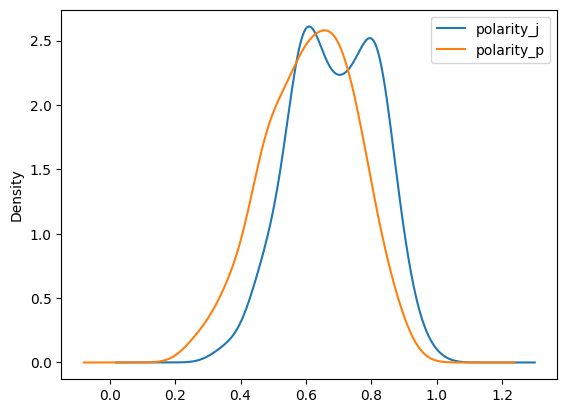

In [28]:
pol_j = val_set_df.iloc[:, 11]
pol_p = val_set_df.iloc[:, 12]

dens_df = pd.concat([pol_j, pol_p], axis=1)
dens_df.plot(kind='density') # or pd.Series()

In [29]:
columns_to_select = list(range(6, 12)) + list(range(13, len(val_set_df.columns)))
val_set_df.iloc[:, columns_to_select]

,j1,j2,j3,j4,j5,polarity_j,price,n_revs_sampled,cat_Arts_&_Photography,cat_Biographies_&_Memoirs,...,subcat_Transportation,subcat_Travelers_&_Explorers,subcat_True_Crime,subcat_United_States,subcat_Water_Sports,subcat_Western,subcat_World,subcat_World_Literature,subcat_Worship_&_Devotion,"subcat_Writing,_Research_&_Publishing_Guides"
217,0.007143,0.003571,0.010714,0.060714,0.917857,0.925000,0.015297,0.014501,False,False,...,False,False,False,False,False,False,False,False,False,True
183,0.021672,0.043344,0.058824,0.191950,0.684211,0.705882,0.048733,0.017362,False,False,...,False,False,False,False,False,False,False,False,False,False
2783,0.000000,0.000000,0.056338,0.394366,0.549296,0.549296,0.048749,0.000599,False,False,...,False,False,False,False,False,False,False,False,False,False
651,0.051724,0.051724,0.043103,0.206897,0.646552,0.698276,0.035877,0.003592,False,False,...,False,False,False,False,False,False,False,False,False,False
613,0.025641,0.000000,0.025641,0.128205,0.820513,0.846154,0.023639,0.001064,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2549,0.128440,0.055046,0.119266,0.137615,0.559633,0.688073,0.030310,0.003126,False,False,...,False,False,False,False,False,False,False,False,False,False
2725,0.045113,0.052632,0.135338,0.187970,0.578947,0.624060,0.020312,0.004723,False,False,...,False,False,False,False,False,False,False,False,False,False
2722,0.000000,0.009709,0.000000,0.155340,0.834951,0.834951,0.018640,0.002727,False,False,...,False,False,False,False,False,False,False,False,False,False
1459,0.052747,0.046154,0.057143,0.120879,0.723077,0.775824,0.016066,0.026142,False,False,...,False,False,False,False,False,False,False,False,False,False


In [30]:
# define dataset with dataloader
class ReviewDataset(Dataset):

    def __init__(self, data):
        # Initialize data, download, etc.
        # read with numpy or pandas
        xy = data.to_numpy()
        self.n_samples = xy.shape[0]

        # class label, features
        self.y_data = torch.from_numpy(xy[:, 1:6].astype(np.float32)) # size [n_samples, 1]
        self.x_data = torch.from_numpy(xy[:, columns_to_select].astype(np.float32))
        #self.x_polarity_p = torch.from_numpy(xy[:, 12].astype(np.float32)) # size [n_samples, n_features]
        self.init_index = torch.from_numpy(xy[:, 0].astype(np.float32)) # size [n_samples, n_features]

        # npdata = data.to_numpy()
        # self.n_samples = len(npdata)
        #
        # # class label, features
        # self.y_data = torch.tensor(npdata.iloc[:, [1,2,3,4,5]].astype(np.float32))
        # self.x_data = torch.tensor(npdata.iloc[:, 6:].astype(np.float32))
        # self.x_polarity_p = torch.tensor(npdata.loc[:, ["polarity_p"]].astype(np.float32))
        # self.init_index = torch.tensor(npdata.loc[:, ["init_index"]].astype(np.float32))

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], \
               self.y_data[index], \
               self.init_index[index]
               #self.x_polarity_p[index], \

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

# create dataset
train_set = ReviewDataset(train_set_df)
val_set = ReviewDataset(val_set_df)
test_set = ReviewDataset(test_set_df)


In [31]:
# Define the batch size
batch_size = 32

In [32]:
train_loader = DataLoader(dataset = train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset = val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset = test_set, batch_size=batch_size, shuffle=False)

In [33]:
input_size = sum([5, # 5 js
                  1, # polarity j
                  #1, # polarity p
                  1, # price
                  1, # n_revs_sampled
                  len_catz, # len categories
                  len_subcatz # len subcategories
                 ]
                 )

print(input_size)
hidden_size = [256, 128, 64, 32]
num_classes = 5


138


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np

torch.autograd.set_detect_anomaly(True)


class NN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = nn.Linear(hidden_size[2], hidden_size[3])
        self.fc5 = nn.Linear(hidden_size[3], num_classes)
        self.relu = nn.ReLU()

        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc5(x)

        return x


class ConstraintLayer(nn.Module):
    def __init__(self):
        super(ConstraintLayer, self).__init__()

    def forward(self, output, x_data):

        # Apply constraint

        zeros_mask_j1 = x_data[:, 0] == 0
        zeros_mask_j2 = x_data[:, 1] == 0

        output_corrected = output.clone()  # Create a copy
        output_corrected = F.softmax(output_corrected, dim=1)

        output_corrected = output_corrected.clone()
        output_corrected[:, 0].masked_fill_(zeros_mask_j1, 0)
        output_corrected[:, 1].masked_fill_(zeros_mask_j2, 0)

        ## NORMALIZE
        # Calculate the sum of each row
        row_sums = torch.sum(output_corrected, dim=1)

        # Normalize each row by dividing by the row sums
        output_corrected = output_corrected / row_sums.unsqueeze(1)

        #output_corrected[:, 0][zeros_mask_j1] = 0
        #output_corrected[:, 1][zeros_mask_j2] = 0

        return output_corrected

NNmodel = NN(input_size, hidden_size, num_classes)
constraint_layer = ConstraintLayer()


In [35]:
# Hyperparameters
num_epochs = 100 # fine tuned based on 300 first
total_samples = n_data
n_iterations = math.ceil(total_samples / batch_size)

# Define a loss function and optimizer
criterion = nn.KLDivLoss()
#criterion = nn.CrossEntropyLoss()
#criterion = torch.nn.NLLLoss()


#scheduler = StepLR(optimizer, step_size=10, gamma=1)

In [36]:
learning_rate = 0.0001 # 0.00001 looks promising
optimizer = torch.optim.Adam(NNmodel.parameters(), lr=learning_rate)

In [38]:
torch.autograd.set_detect_anomaly(True)

min_valid_loss = np.inf
NNmodel_performance_df = pd.DataFrame(columns = ['epoch', 'training_loss', 'validation_loss'])

for epoch in range(num_epochs):

    train_loss = 0.0
    NNmodel.train()     # Optional when not using Model Specific layer

    for x_data, \
        y_data, \
        init_index in train_loader:

        optimizer.zero_grad()

        outputs = NNmodel(x_data)
        outputs_before_constraint = outputs.clone()  # Model output before applying constraint

        outputs_corrected = constraint_layer(outputs, x_data)
        outputs_corrected_log_softmax = F.log_softmax(outputs_corrected)

        # STUFF FOR COMPLEX LOSS FCT
        #outputs_KLDiv = torch.nn.functional.log_softmax(outputs, dim=1)
        outputs_KLDiv = outputs_corrected_log_softmax
#        outputs_polarity_p = torch.nn.functional.softmax(outputs, dim=1)

        # Add the first and fifth value of each row of the input tensor
 #       polarity_p_pred = outputs_polarity_p[:, 0] + outputs_polarity_p[:, 4]

        # Calculate loss
        loss = criterion(outputs_KLDiv, y_data)
        #loss = criterion(outputs, y_data)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    valid_loss = 0.0
    NNmodel.eval()     # Optional when not using Model Specific layer

    for x_data, \
        y_data, \
        init_index in val_loader:

        outputs = NNmodel(x_data)
        outputs_before_constraint = outputs.clone()  # Model output before applying constraint

        outputs_corrected = constraint_layer(outputs, x_data)
        outputs_corrected_log_softmax = F.log_softmax(outputs_corrected)

        # STUFF FOR COMPLEX LOSS FCT
        #outputs_KLDiv = torch.nn.functional.log_softmax(outputs, dim=1)
        outputs_KLDiv = outputs_corrected_log_softmax
 #       outputs_polarity_p = torch.nn.functional.softmax(outputs, dim=1)

        # Add the first and fifth value of each row of the input tensor
#        polarity_p_pred = outputs_polarity_p[:, 0] + outputs_polarity_p[:, 4]

        # Calculate loss
        loss = criterion(outputs_KLDiv, y_data)
        #loss = criterion(outputs, y_data)

        valid_loss = loss.item() * x_data.size(0)

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')

    # SAVE EPOCH LOSS DATA
    NNmodel_performance_df.loc[epoch, 'epoch'] = epoch
    NNmodel_performance_df.loc[epoch, 'training_loss'] = train_loss / len(train_loader)
    NNmodel_performance_df.loc[epoch, 'validation_loss'] = valid_loss / len(val_loader)

    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss

        #Saving State Dict
        torch.save(NNmodel.state_dict(), '0006_03_00_saved_NNmodel.pth')

Epoch 1 		 Training Loss: 0.11333175586028532 		 Validation Loss: 0.39012869766780306
Validation Loss Decreased(inf--->2.730901) 	 Saving The Model
Epoch 2 		 Training Loss: 0.09431291073560714 		 Validation Loss: 0.2641235589981079
Validation Loss Decreased(2.730901--->1.848865) 	 Saving The Model
Epoch 3 		 Training Loss: 0.06424968195232478 		 Validation Loss: 0.21824000775814056
Validation Loss Decreased(1.848865--->1.527680) 	 Saving The Model
Epoch 4 		 Training Loss: 0.0596781001849608 		 Validation Loss: 0.21685804426670074
Validation Loss Decreased(1.527680--->1.518006) 	 Saving The Model
Epoch 5 		 Training Loss: 0.059212346307256004 		 Validation Loss: 0.21660416679722921
Validation Loss Decreased(1.518006--->1.516229) 	 Saving The Model
Epoch 6 		 Training Loss: 0.05918609303506938 		 Validation Loss: 0.2165045834013394
Validation Loss Decreased(1.516229--->1.515532) 	 Saving The Model
Epoch 7 		 Training Loss: 0.05906041271307252 		 Validation Loss: 0.2164642768246787
Vali

Epoch 66 		 Training Loss: 0.058941097489812154 		 Validation Loss: 0.21640778120074952
Epoch 67 		 Training Loss: 0.058996121246706355 		 Validation Loss: 0.21640778120074952
Epoch 68 		 Training Loss: 0.058953605524518275 		 Validation Loss: 0.21640778120074952
Epoch 69 		 Training Loss: 0.05899368829347871 		 Validation Loss: 0.21640778120074952
Epoch 70 		 Training Loss: 0.05891495448621836 		 Validation Loss: 0.21640778120074952
Epoch 71 		 Training Loss: 0.05888525112108751 		 Validation Loss: 0.21640778120074952
Epoch 72 		 Training Loss: 0.05894362018866973 		 Validation Loss: 0.216407767363957
Validation Loss Decreased(1.514854--->1.514854) 	 Saving The Model
Epoch 73 		 Training Loss: 0.05896306579763239 		 Validation Loss: 0.216407767363957
Epoch 74 		 Training Loss: 0.05893019044941122 		 Validation Loss: 0.216407767363957
Epoch 75 		 Training Loss: 0.058938957073471764 		 Validation Loss: 0.216407767363957
Epoch 76 		 Training Loss: 0.05892928879369389 		 Validation Loss: 

In [39]:
from matplotlib.pylab import plt
from scipy.interpolate import splrep, splev

# Get them data
train_values = NNmodel_performance_df.training_loss.astype('float')
val_values = NNmodel_performance_df.validation_loss.astype('float')
epochs = NNmodel_performance_df.epoch.astype('float')

# Smooth it
smooth_train = splrep(epochs, train_values, s=0.0002)
smooth_train_values = splev(epochs, smooth_train)

smooth_val = splrep(epochs, val_values, s=0.0002)
smooth_val_values = splev(epochs, smooth_val)

df_smooth_val = pd.DataFrame(smooth_val_values)
#df_smooth_val = pd.concat([df_smooth_val, epochs])
df_smooth_val.columns = ["val"]

# get min of smoothed
min_index = df_smooth_val['val'].idxmin()
min_index




3

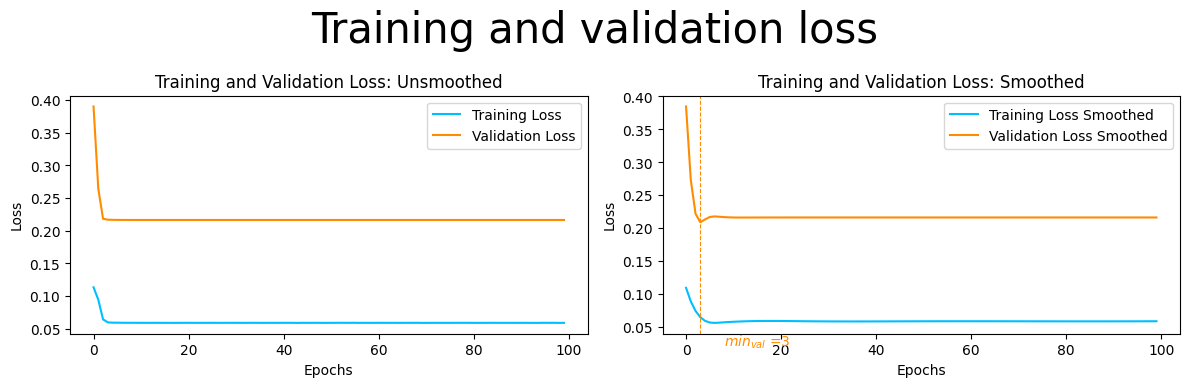

In [40]:
# Plot it
# Create a figure with 2 subplots, one for each variable
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
fig.subplots_adjust(hspace=4, top=2)
fig.suptitle('Training and validation loss', fontsize=30)

axs[0].plot(epochs, train_values, label='Training Loss', color='deepskyblue')
axs[0].plot(epochs, val_values, label='Validation Loss', color='darkorange')
axs[0].set_title('Training and Validation Loss: Unsmoothed')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='best')
#axs[0].axvline(min_index, color='red', linestyle='--')  # Add vertical red line



axs[1].plot(epochs,smooth_train_values, label = 'Training Loss Smoothed', color='deepskyblue')
axs[1].plot(epochs,smooth_val_values, label = 'Validation Loss Smoothed', color='darkorange')
axs[1].set_title('Training and Validation Loss: Smoothed')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='best')
axs[1].axvline(min_index, color='darkorange', linestyle='--', linewidth=0.8)  # Add vertical red line
axs[1].text(min_index+5, 0.015, "$min_{val}$ ="+ f'{min_index}', color='darkorange', ha='left', va='bottom')  # Add red text label

# axs[1].get_ylim()[1]
fig.tight_layout()
plt.show()

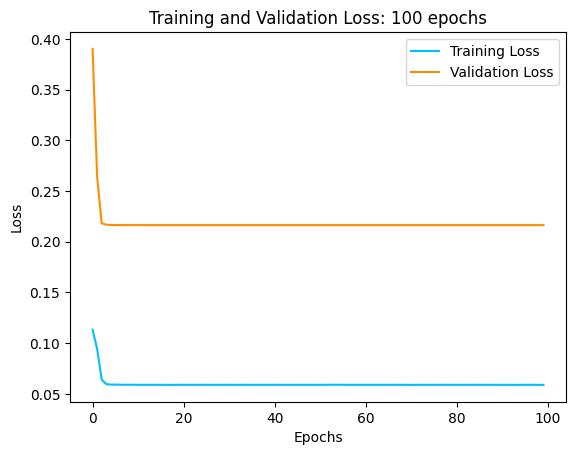

In [41]:
# Plot it
# Create a figure with 2 subplots, one for each variable

plt.plot(epochs, train_values, label='Training Loss', color='deepskyblue')
plt.plot(epochs, val_values, label='Validation Loss', color='darkorange')
plt.title('Training and Validation Loss:' f' {num_epochs} ' 'epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
#axs[0].axvline(min_index, color='red', linestyle='--')  # Add vertical red line

# axs[1].get_ylim()[1]
fig.tight_layout()
plt.show()

In [42]:
#Get raw data
y_data_raw_val = val_set_df[['p1', 'p2', 'p3', 'p4', 'p5']]
x_data_raw_val = val_set_df.drop(columns=['p1', 'p2', 'p3', 'p4', 'p5'])
#
# # Get column names of original data for later
columns_y_data_raw_val = y_data_raw_val.columns.tolist()
columns_x_data_raw_val = x_data_raw_val.columns.tolist()
#
# # Get initial data for prediction
# x_data = df_books_data_model.drop(columns=['p1', 'p2', 'p3', 'p4', 'p5']).values
# y_data = df_books_data_model[['p1', 'p2', 'p3', 'p4', 'p5']].values
#
# # tensor setup
# x_data_tensor = test_set.x_data
# y_data_tensor = test_set.y_data
# indexes = test_set.init_index

# Predictions
with torch.no_grad():
    y_pred_precorrection = NNmodel(val_set.x_data)
    y_pred = constraint_layer(y_pred_precorrection, val_set.x_data)

# Convert predictions to numpy array
y_pred_val = y_pred.numpy()
# Save the input data and the predictions in a CSV file
# Combine the input data and the predictions into a single numpy array
output_data_val = np.concatenate((y_pred_val, y_data_raw_val, x_data_raw_val), axis=1)

# Create a pandas dataframe from the numpy array
output_df_val = pd.DataFrame(output_data_val, columns=['p1_pred', 'p2_pred', 'p3_pred', 'p4_pred',
                                                         'p5_pred'] + columns_y_data_raw_val + columns_x_data_raw_val)

output_df_val['polarity_p_pred'] = output_df_val['p1_pred'] + output_df_val['p5_pred']

# Save the dataframe to a CSV file
#output_df_val.to_csv('02_Output/0006_03_01_p_prediction_model7_MAbased_update_val.csv', index=False)
output_df_val.head()

,p1_pred,p2_pred,p3_pred,p4_pred,p5_pred,p1,p2,p3,p4,p5,...,subcat_Travelers_&_Explorers,subcat_True_Crime,subcat_United_States,subcat_Water_Sports,subcat_Western,subcat_World,subcat_World_Literature,subcat_Worship_&_Devotion,"subcat_Writing,_Research_&_Publishing_Guides",polarity_p_pred
0,0.0,0.0,0.0,0.0,1.0,0.025,0.0,0.064286,0.157143,0.753571,...,False,False,False,False,False,False,False,False,True,1.0
1,0.0,0.0,0.0,0.0,1.0,0.012384,0.037152,0.136223,0.272446,0.541796,...,False,False,False,False,False,False,False,False,False,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.098592,0.253521,0.647887,...,False,False,False,False,False,False,False,False,False,1.0
3,0.0,0.0,0.0,0.0,1.0,0.008621,0.008621,0.12931,0.103448,0.75,...,False,False,False,False,False,False,False,False,False,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.064103,0.217949,0.192308,0.525641,...,False,False,False,False,False,False,False,False,False,1.0


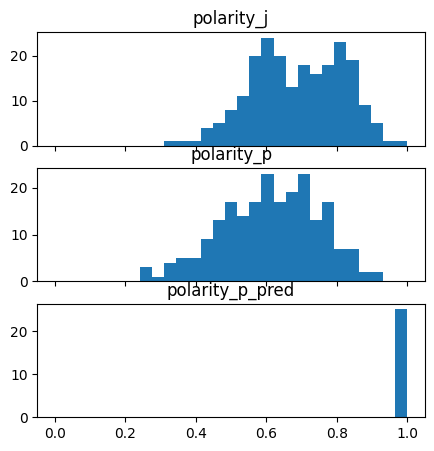

In [43]:
bins = np.linspace(0,1,30,endpoint=True)

# Create a figure with 3 subplots arranged in one row
fig, axs = plt.subplots(3, 1, figsize=(5, 5), sharex = 'all')

# Create a histogram for each dataset and add it to a subplot
axs[0].hist(output_df_val[['polarity_j']], bins=bins)
axs[1].hist(output_df_val[['polarity_p']], bins=bins)
axs[2].hist(output_df_val[['polarity_p_pred']], bins=bins)

# Set the title for each subplot
axs[0].set_title('polarity_j')
axs[1].set_title('polarity_p')
axs[2].set_title('polarity_p_pred')

# Show the plot
plt.show()

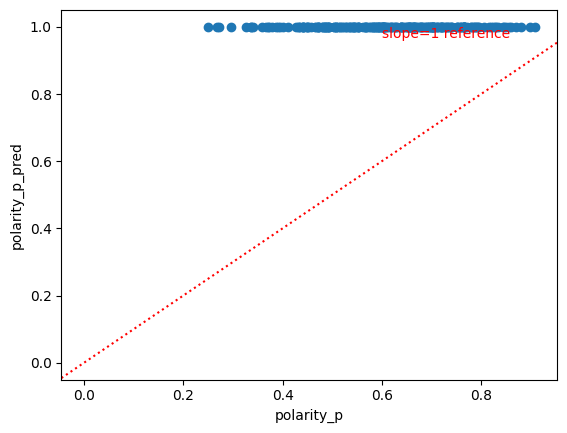

In [44]:
#plt, ax = plt.subplots()

plt.scatter(x  = output_df_val.polarity_p, y = output_df_val.polarity_p_pred)
plt.axline((0, 0), slope=1, color='r', linestyle='dotted')
plt.xlabel("polarity_p")
plt.ylabel("polarity_p_pred")
plt.text(0.6, 1, 'slope=1 reference', fontsize=10, color = "red", verticalalignment='top')

plt.show()

r2 =  0.004531120744450057
                                 OLS Regression Results                                
Dep. Variable:                p1_pred   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                             0.9877
Date:                Thu, 29 Jun 2023   Prob (F-statistic):                       0.321
Time:                        21:41:36   Log-Likelihood:                          5527.5
No. Observations:                 218   AIC:                                 -1.105e+04
Df Residuals:                     217   BIC:                                 -1.105e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------

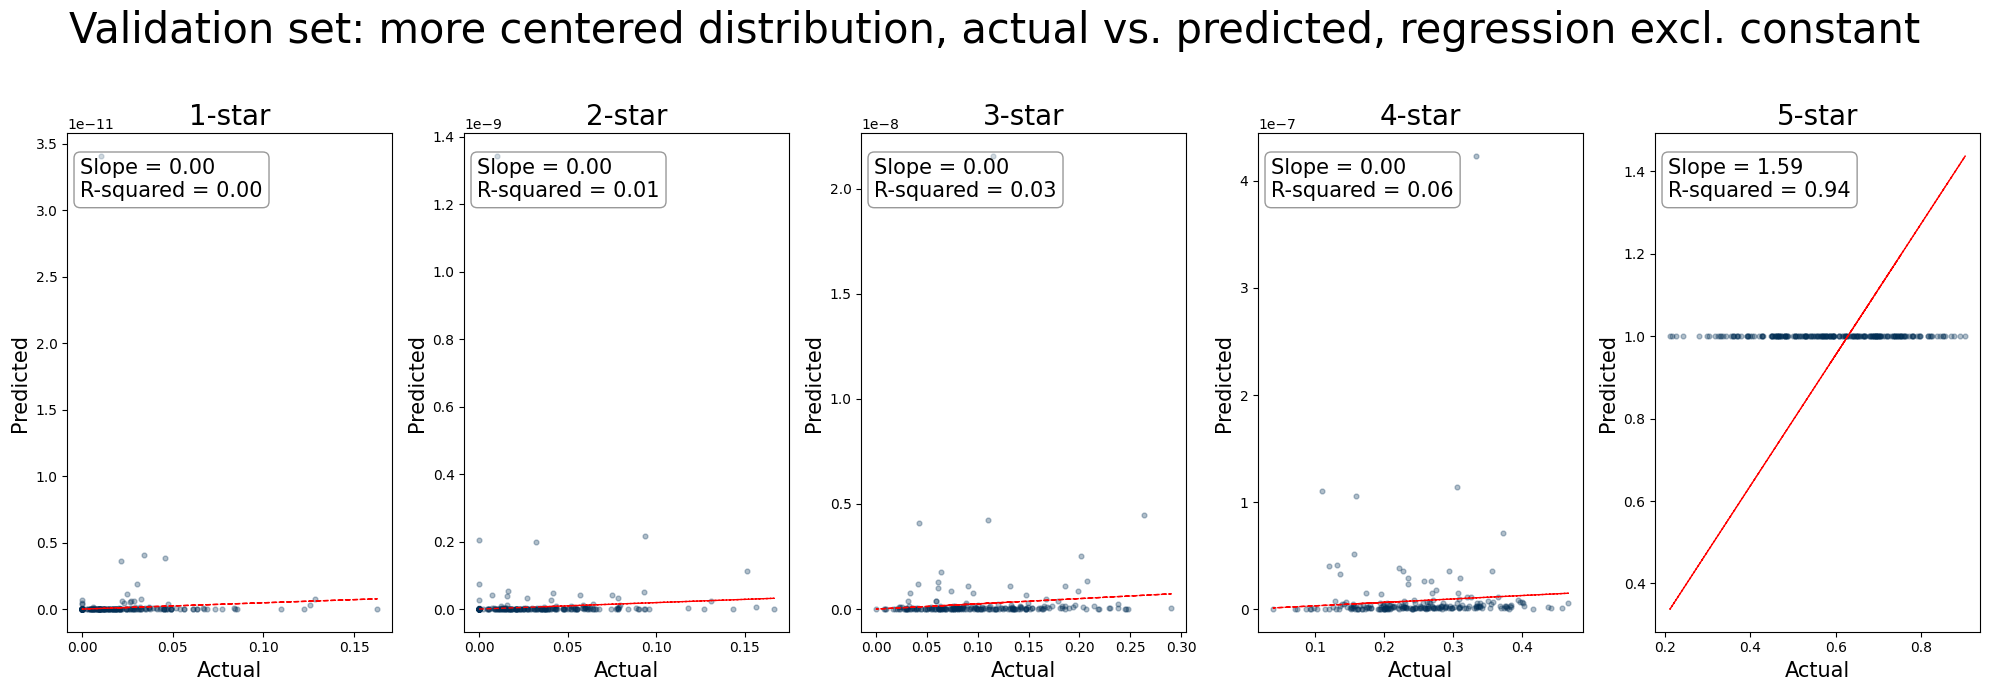

In [45]:
df = output_df_val

df[['p1', 'p2', 'p3', 'p4', 'p5', 'p1_pred', 'p2_pred', 'p3_pred', 'p4_pred', 'p5_pred']] = df[['p1', 'p2', 'p3', 'p4', 'p5', 'p1_pred', 'p2_pred', 'p3_pred', 'p4_pred', 'p5_pred']].astype('float64')

# Create a figure with 5 subplots, one for each variable
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,7))
#fig.subplots_adjust(hspace=8)
fig.suptitle('Validation set: more centered distribution, actual vs. predicted, regression excl. constant', fontsize=30)

for i, var in enumerate(['1', '2', '3', '4', '5']):
    # Calculate the regression slope and R-squared without intercept using Statsmodels
    x = df[f'p{var}']
    y = df[f'p{var}_pred']
    #X = sm.add_constant(x)
    OLSmodel = sm.OLS(y, x).fit()
    slope = OLSmodel.params[0]
    regression_line = OLSmodel.params[0] * x
    #regression_line = OLSmodel.params[0] + OLSmodel.params[1] * x
    r2 = OLSmodel.rsquared
    print(f'r2 =  {r2}')
    axs[i].scatter(x, y, alpha = 0.3, s = 12, color = "#022F55")
    axs[i].set_xlabel("Actual", fontsize = 15)
    axs[i].set_ylabel("Predicted", fontsize = 15)

    print(OLSmodel.summary())


    # Add the slope and R-squared as text in the upper right corner of the subplot
    textstr = f'Slope = {slope:.2f}\nR-squared = {r2:.2f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.4)
    axs[i].text(0.04, 0.95, textstr, transform=axs[i].transAxes, fontsize=15, verticalalignment='top', bbox=props)
    axs[i].set_title(f'{var}' + "-star", fontsize=20)
    axs[i].plot(x, regression_line, color='red', alpha = 1, linestyle = "dashed", linewidth = 1)

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])


plt.show()

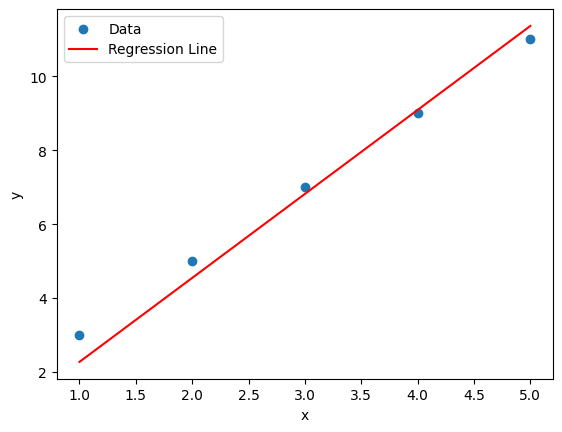

In [46]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Input data
x = np.array([1, 2, 3, 4, 5])  # Independent variable
y = np.array([3, 5, 7, 9, 11])  # Dependent variable

# Create and fit OLS model without intercept
model = sm.OLS(y, x)
results = model.fit()

# Regression line
regression_line = results.params[0] * x

# Scatter plot
plt.scatter(x, y, label='Data')

# Regression line plot
plt.plot(x, regression_line, color='red', label='Regression Line')

# Labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()


# RESIDUALS

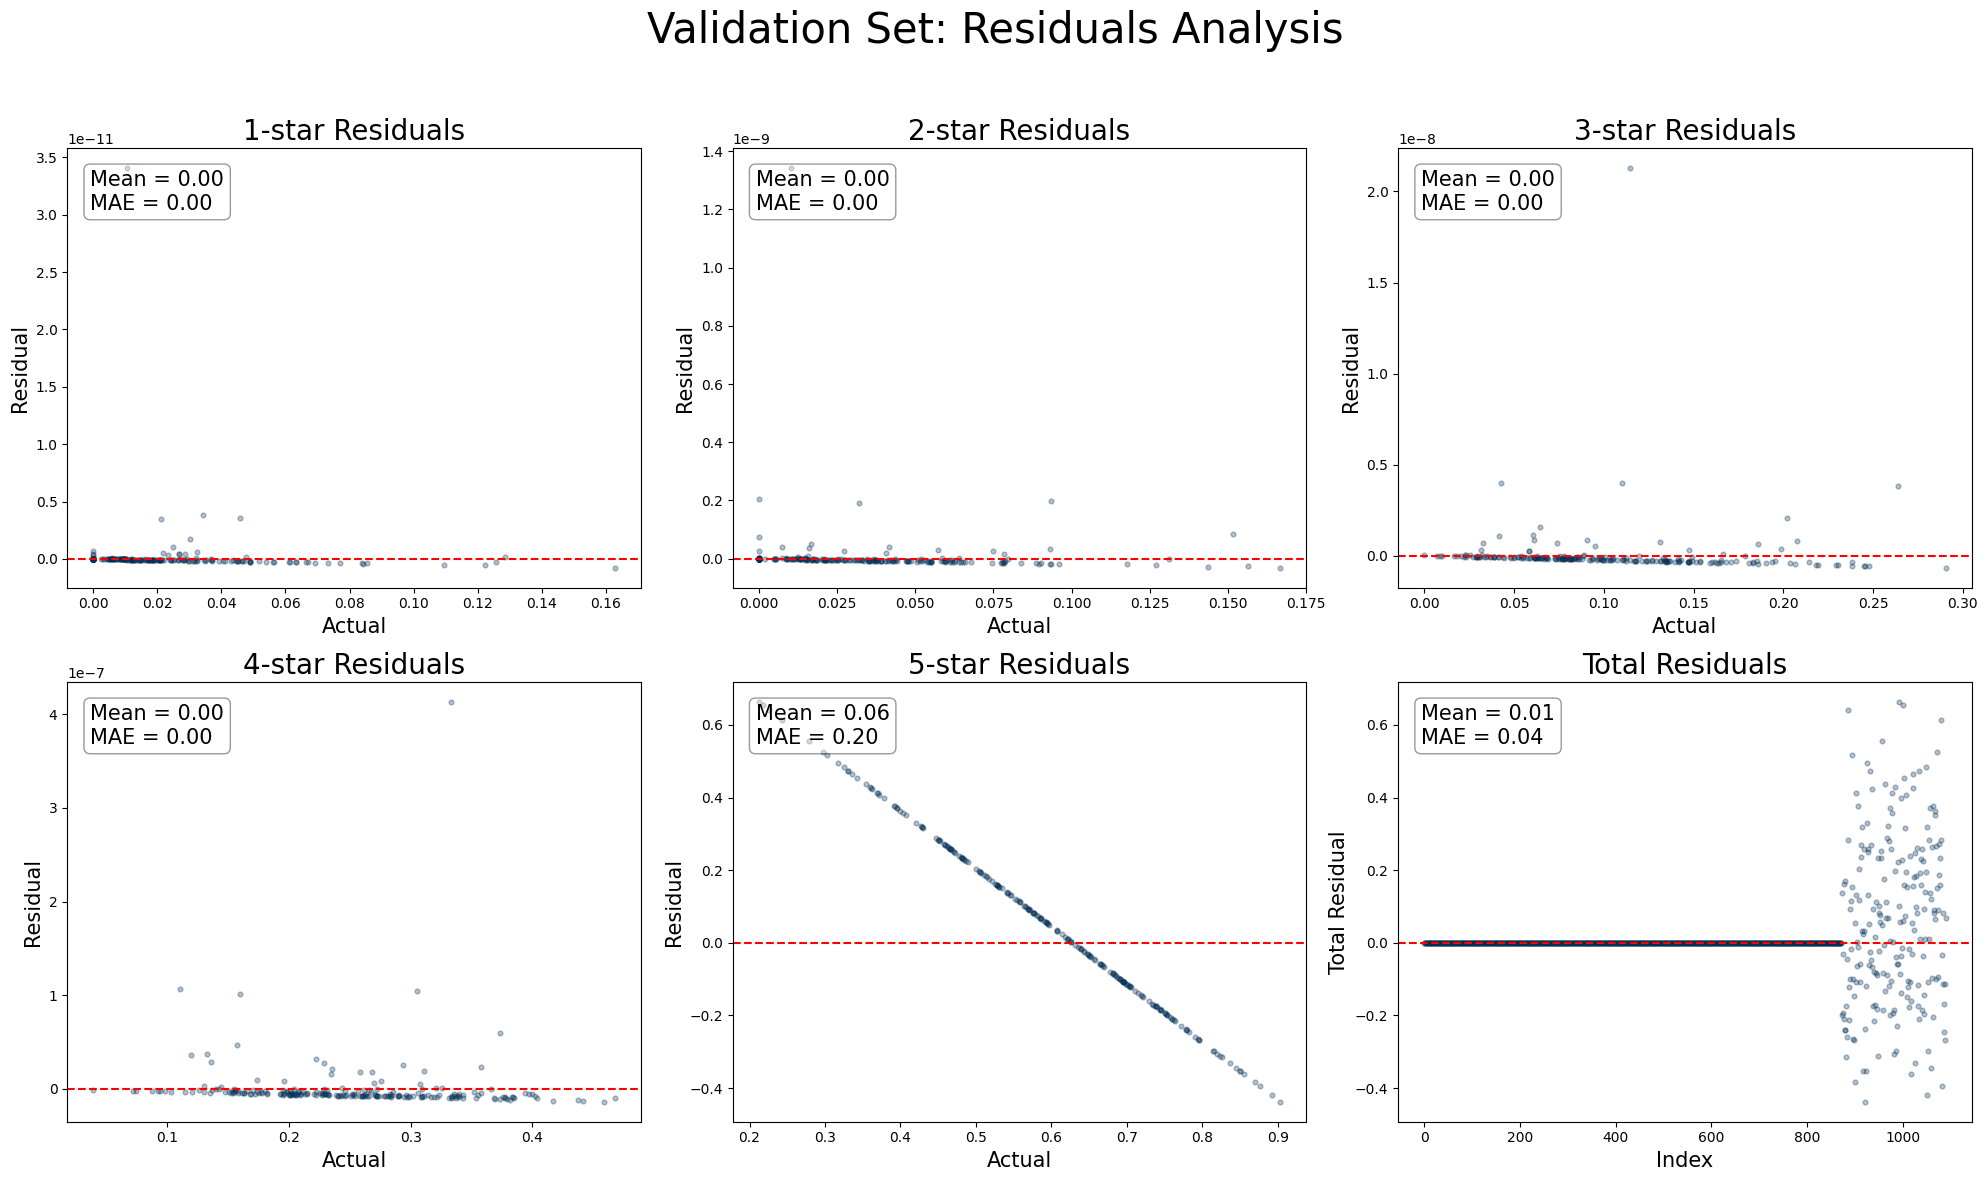

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

df = output_df_val

df[['p1', 'p2', 'p3', 'p4', 'p5', 'p1_pred', 'p2_pred', 'p3_pred', 'p4_pred', 'p5_pred']] = df[['p1', 'p2', 'p3', 'p4', 'p5', 'p1_pred', 'p2_pred', 'p3_pred', 'p4_pred', 'p5_pred']].astype('float64')

# Create a figure with 6 subplots (5 for residuals + 1 for total residuals)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
fig.suptitle('Validation Set: Residuals Analysis', fontsize=30)

# Create lists to store total residuals and subplot axes
total_residuals = []
subplot_axes = []

# Iterate over each variable
for i, var in enumerate(['1', '2', '3', '4', '5']):
    # Calculate the regression slope and R-squared without intercept using Statsmodels
    x = df[f'p{var}']
    y = df[f'p{var}_pred']
    OLSmodel = sm.OLS(y, x, hasconst=False).fit()
    slope = OLSmodel.params[f'p{var}']
    r2 = OLSmodel.rsquared
    residuals = y - slope * x

    # Store total residuals for later use
    total_residuals.append(residuals)

    # Scatter plot of residuals
    ax = axs[i//3, i%3]
    ax.scatter(x, residuals, alpha=0.3, s=12, color="#022F55")
    ax.axhline(0.00, color='red', linestyle='--')  # Add red horizontal line at 0.00
    ax.set_xlabel("Actual", fontsize=15)
    ax.set_ylabel("Residual", fontsize=15)
    ax.set_title(f'{var}-star Residuals', fontsize=20)
    subplot_axes.append(ax)

    # Calculate measure(s) of total residual (e.g., mean absolute error)
    total_residual_mean = np.mean(residuals)
    total_residual_mae = np.mean(np.abs(residuals))

    # Add the measure(s) as text in the upper right corner of the subplot
    textstr = f'Mean = {total_residual_mean:.2f}\nMAE = {total_residual_mae:.2f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.4)
    ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)

# Scatter plot of total residuals
total_residuals = np.concatenate(total_residuals)
ax = axs[1, 2]
ax.scatter(np.arange(len(total_residuals)), total_residuals, alpha=0.3, s=12, color="#022F55")
ax.axhline(0.00, color='red', linestyle='--')  # Add red horizontal line at 0.00
ax.set_xlabel("Index", fontsize=15)
ax.set_ylabel("Total Residual", fontsize=15)
ax.set_title("Total Residuals", fontsize=20)

# Calculate measure(s) of total residuals (e.g., mean absolute error)
total_residual_mean = np.mean(total_residuals)
total_residual_mae = np.mean(np.abs(total_residuals))

# Add measure(s) as text in the upper right corner of the subplot
textstr = f'Mean = {total_residual_mean:.2f}\nMAE = {total_residual_mae:.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.4)
ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)

# Adjust the layout of subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()


# TESTING

In [48]:
# Test the model and save the results
NNmodel.eval()

# Test the model
with torch.no_grad():
    total_loss = 0.0
    KL_div_loss = 0.0
    polarity_loss = 0.0
    n_samples = 0
    avg_total_loss = 0.0
    avg_KL_div_loss = 0.0
    avg_polarity_loss = 0.0

# x_polarity_p,

    for x_data, y_data, init_index in test_loader:
        # Forward pass
        outputs = NNmodel(x_data)
        outputs_before_constraint = outputs.clone()  # Model output before applying constraint

        outputs_corrected = constraint_layer(outputs, x_data)
        outputs_corrected_log_softmax = F.log_softmax(outputs_corrected)

        outputs_polarity_p = torch.nn.functional.softmax(outputs, dim=1)
        polarity_p_pred = outputs_polarity_p[:, 0] + outputs_polarity_p[:, 4]

        total_loss += criterion(outputs_corrected_log_softmax, y_data)

        # Update number of samples
        n_samples += y_data.size(0)

    # Calculate average loss
    avg_total_loss = total_loss / n_samples
    avg_KL_div_loss = KL_div_loss / n_samples
    avg_polarity_loss = polarity_loss / n_samples


    # Print losses avg
    print(f'Loss data on testing set with {n_samples:d} samples')
    print(f'AVG total loss: {avg_total_loss:.4f}')
    # Print losses abs
    print(f'ABS total loss: {total_loss.item():.4f}')



Loss data on testing set with 219 samples
AVG total loss: 0.0020
ABS total loss: 0.4393


In [49]:
n_samples

219

In [50]:
#Get raw data
y_data_raw_test = test_set_df[['p1', 'p2', 'p3', 'p4', 'p5']]
x_data_raw_test = test_set_df.drop(columns=['p1', 'p2', 'p3', 'p4', 'p5'])
#
# # Get column names of original data for later
columns_y_data_raw_test = y_data_raw_test.columns.tolist()
columns_x_data_raw_test = x_data_raw_test.columns.tolist()
#
# # Get initial data for prediction
# x_data = df_books_data_model.drop(columns=['p1', 'p2', 'p3', 'p4', 'p5']).values
# y_data = df_books_data_model[['p1', 'p2', 'p3', 'p4', 'p5']].values
#
# # tensor setup
# x_data_tensor = test_set.x_data
# y_data_tensor = test_set.y_data
# indexes = test_set.init_index

# Predictions
with torch.no_grad():
    y_pred_precorrection = NNmodel(test_set.x_data)
    outputs_before_constraint = y_pred_precorrection.clone()  # Model output before applying constraint
    y_pred = constraint_layer(outputs_before_constraint, test_set.x_data)

    #outputs_corrected_log_softmax = F.log_softmax(outputs_corrected)
    #y_pred = torch.nn.functional.softmax(y_pred, dim=1)

# Convert predictions to numpy array
y_pred_test = y_pred.numpy()

In [52]:
# Save the input data and the predictions in a CSV file
# Combine the input data and the predictions into a single numpy array
output_data_test = np.concatenate((y_pred_test, y_data_raw_test, x_data_raw_test), axis=1)

# Create a pandas dataframe from the numpy array
output_df_test = pd.DataFrame(output_data_test, columns=['p1_pred', 'p2_pred', 'p3_pred', 'p4_pred', 'p5_pred'] + columns_y_data_raw_test + columns_x_data_raw_test)

output_df_test['polarity_p_pred'] = output_df_test['p1_pred'] + output_df_test['p5_pred']

# Save the dataframe to a CSV file
output_df_test.to_csv('0006_03_02_ML_model_outputs_testingdata_UPDATED.csv', index=False)

In [53]:
output_df_test.head()

,p1_pred,p2_pred,p3_pred,p4_pred,p5_pred,p1,p2,p3,p4,p5,...,subcat_Travelers_&_Explorers,subcat_True_Crime,subcat_United_States,subcat_Water_Sports,subcat_Western,subcat_World,subcat_World_Literature,subcat_Worship_&_Devotion,"subcat_Writing,_Research_&_Publishing_Guides",polarity_p_pred
0,0.0,0.0,0.0,0.0,1.0,0.0,0.005236,0.073298,0.230366,0.691099,...,False,False,False,False,False,False,False,False,False,1.0
1,0.0,0.0,0.0,0.0,1.0,0.036667,0.043333,0.1,0.293333,0.526667,...,False,False,False,False,False,False,False,False,False,1.0
2,0.0,0.0,0.0,0.0,1.0,0.024096,0.018072,0.018072,0.222892,0.716867,...,False,False,False,False,False,False,False,False,False,1.0
3,0.0,0.0,0.0,0.0,1.0,0.02027,0.128378,0.081081,0.290541,0.47973,...,False,False,False,False,False,False,False,False,False,1.0
4,0.0,0.0,0.0,0.0,1.0,0.019512,0.012195,0.05,0.280488,0.637805,...,False,False,False,False,False,False,False,False,False,1.0


In [54]:
len(output_df_test)

219

r2 =  0.012105007672881807
r2 =  0.12089180634051455
r2 =  0.07044521413427263
r2 =  0.06726129810968506
r2 =  0.9497541480297109


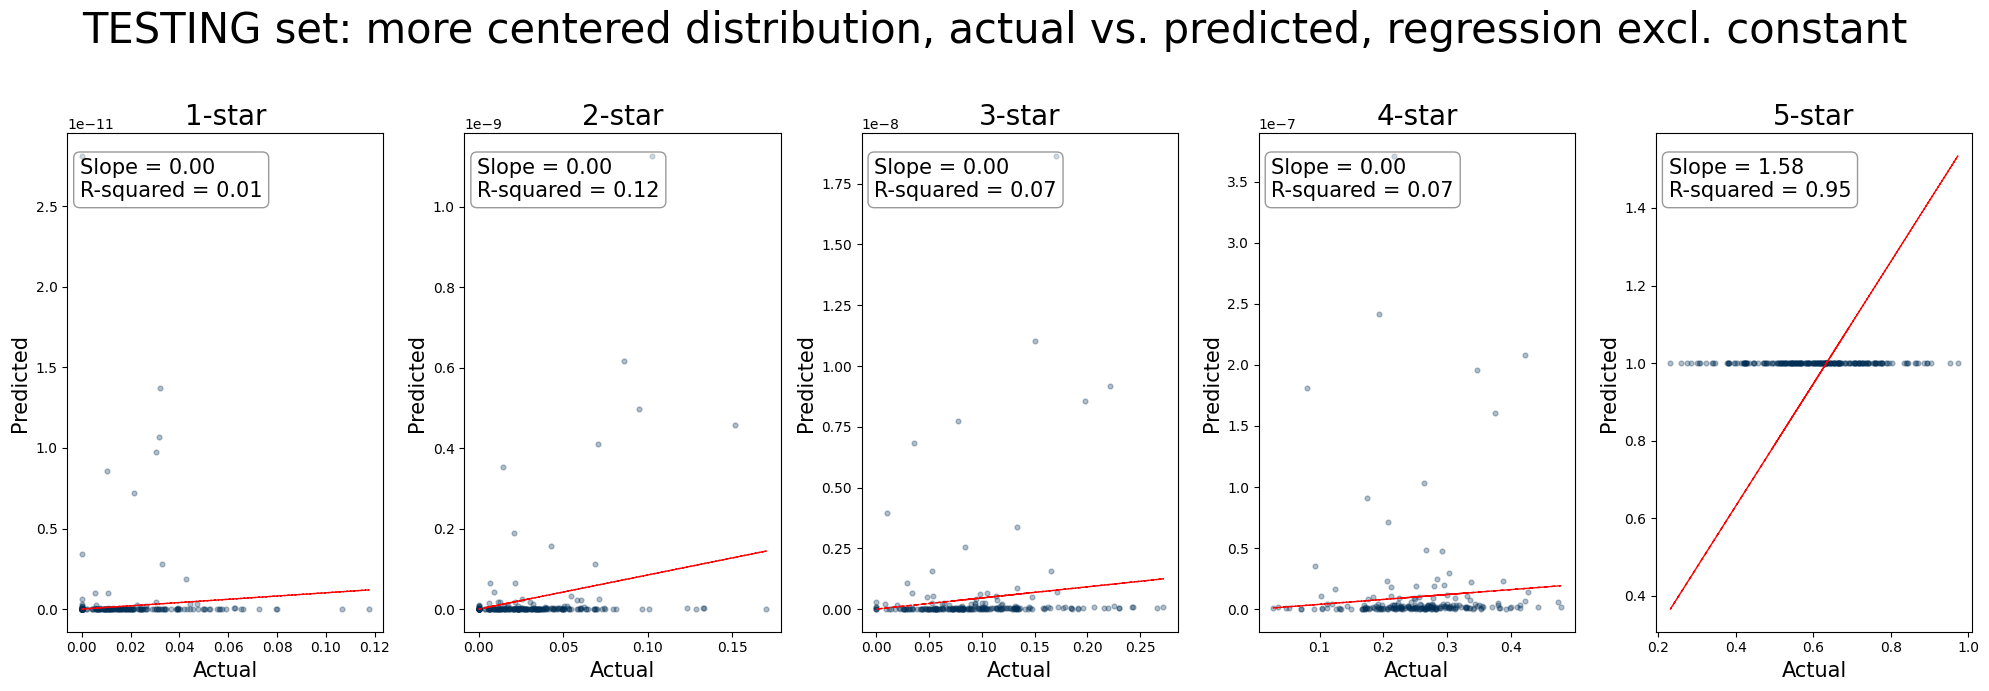

In [55]:
df = output_df_test

df[['p1', 'p2', 'p3', 'p4', 'p5', 'p1_pred', 'p2_pred', 'p3_pred', 'p4_pred', 'p5_pred']] = df[['p1', 'p2', 'p3', 'p4', 'p5', 'p1_pred', 'p2_pred', 'p3_pred', 'p4_pred', 'p5_pred']].astype('float64')

# Create a figure with 5 subplots, one for each variable
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,7))
#fig.subplots_adjust(hspace=8)
fig.suptitle('TESTING set: more centered distribution, actual vs. predicted, regression excl. constant', fontsize=30)

for i, var in enumerate(['1', '2', '3', '4', '5']):
    # Calculate the regression slope and R-squared without intercept using Statsmodels
    x = df[f'p{var}']
    y = df[f'p{var}_pred']
    OLSmodel = sm.OLS(y, x, hasconst=False).fit()
    slope = OLSmodel.params[f'p{var}']
    r2 = OLSmodel.rsquared
    print(f'r2 =  {r2}')
    axs[i].scatter(x, y, alpha = 0.3, s = 12, color = "#022F55")
    axs[i].set_xlabel("Actual", fontsize = 15)
    axs[i].set_ylabel("Predicted", fontsize = 15)

    # Add the slope and R-squared as text in the upper right corner of the subplot
    textstr = f'Slope = {slope:.2f}\nR-squared = {r2:.2f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.4)
    axs[i].text(0.04, 0.95, textstr, transform=axs[i].transAxes, fontsize=15, verticalalignment='top', bbox=props)
    axs[i].set_title(f'{var}' + "-star", fontsize=20)
    axs[i].plot(x, slope * x, color='red', alpha = 1, linestyle = "dashed", linewidth = 1)

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])


plt.show()